In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'MOS'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,2857,-2416,441,208,5293,543,1433,8106,1794,...,19554,570,23,0,3266,3009,8252,934,-468,375.6
1,2014-03-31,1986,-1575,412,221,2491,597,1607,5356,1765,...,18112,593,41,0,2163,3009,7280,-262,525,375.6
2,2014-06-30,2440,-1919,521,250,2367,604,1580,5189,1793,...,18294,750,13,1,1923,3013,7048,796,-214,375.6
3,2014-09-30,2251,-1836,415,207,2971,574,1472,5660,1741,...,18456,762,0,41,1549,3774,7511,357,-188,375.6
4,2014-12-31,2379,-1800,579,354,2375,754,1718,5216,1807,...,18283,797,14,41,1597,3778,7580,342,-252,375.6


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,356.0,4481,-3513,968,471,735,1700,3543,...,0,23386,2044,225,985,5534,2412,11331,956,-341
37,2023-03-31,2023-04-21,333.2,3604,-2934,670,428,465,1426,3320,...,0,22858,1571,855,980,5167,2409,10964,149,-322
38,2023-06-30,2023-07-21,333.2,3394,-2823,571,366,626,1222,3149,...,0,23140,1826,229,970,4840,2423,10735,1073,-310
39,2023-09-30,2023-10-21,333.2,3548,-3139,410,-13,591,1399,2453,...,0,22654,1706,300,955,4696,2402,10604,647,-412
40,2023-12-31,2024-02-11,333.2,3150,-2590,560,368,349,1269,2523,...,0,23033,1567,400,130,3874,3232,10743,538,-359


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,356.0,4481,-3513,968,471,735,1700,3543,...,23386,2044,225,985,5534,2412,11331,956,-341,1
37,2023-03-31,2023-04-21,333.2,3604,-2934,670,428,465,1426,3320,...,22858,1571,855,980,5167,2409,10964,149,-322,1
38,2023-06-30,2023-07-21,333.2,3394,-2823,571,366,626,1222,3149,...,23140,1826,229,970,4840,2423,10735,1073,-310,1
39,2023-09-30,2023-10-21,333.2,3548,-3139,410,-13,591,1399,2453,...,22654,1706,300,955,4696,2402,10604,647,-412,1
40,2023-12-31,2024-02-11,333.2,3150,-2590,560,368,349,1269,2523,...,23033,1567,400,130,3874,3232,10743,538,-359,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,356.0,4481.0,-3513.0,968.0,471.0,735.0,1700.0,3543.0,...,23386.0,2044.0,225.0,985.0,5534.0,2412.0,11331.0,956.0,-341.0,1
37,2023-03-31,2023-04-21,333.2,3604.0,-2934.0,670.0,428.0,465.0,1426.0,3320.0,...,22858.0,1571.0,855.0,980.0,5167.0,2409.0,10964.0,149.0,-322.0,1
38,2023-06-30,2023-07-21,333.2,3394.0,-2823.0,571.0,366.0,626.0,1222.0,3149.0,...,23140.0,1826.0,229.0,970.0,4840.0,2423.0,10735.0,1073.0,-310.0,1
39,2023-09-30,2023-10-21,333.2,3548.0,-3139.0,410.0,-13.0,591.0,1399.0,2453.0,...,22654.0,1706.0,300.0,955.0,4696.0,2402.0,10604.0,647.0,-412.0,1
40,2023-12-31,2024-02-11,333.2,3150.0,-2590.0,560.0,368.0,349.0,1269.0,2523.0,...,23033.0,1567.0,400.0,130.0,3874.0,3232.0,10743.0,538.0,-359.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,39.855686,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,0.577989,0.422011,21.046041,16.954386,2.159078,6.743894,0.154358,0.072804,0.042549,0.073615
1,2014-02-24,40.544422,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,0.577989,0.422011,21.046041,16.954386,2.159078,6.743894,0.154358,0.072804,0.042549,0.073615
2,2014-03-03,41.266357,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,0.577989,0.422011,21.046041,16.954386,2.159078,6.743894,0.154358,0.072804,0.042549,0.073615
3,2014-03-10,39.951721,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,0.577989,0.422011,21.046041,16.954386,2.159078,6.743894,0.154358,0.072804,0.042549,0.073615
4,2014-03-17,40.577271,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,0.577989,0.422011,21.046041,16.954386,2.159078,6.743894,0.154358,0.072804,0.042549,0.073615


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,39.855686,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,6.743894,0.154358,0.072804,0.042549,0.073615,17.992543,1.324526,1.309923,1.568848,2.669364
1,2014-02-24,40.544422,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,6.743894,0.154358,0.072804,0.042549,0.073615,18.303467,1.347415,1.332559,1.591485,2.715493
2,2014-03-03,41.266357,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,6.743894,0.154358,0.072804,0.042549,0.073615,18.629380,1.371407,1.356287,1.615212,2.763845
3,2014-03-10,39.951721,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,6.743894,0.154358,0.072804,0.042549,0.073615,18.035897,1.327718,1.313079,1.572004,2.675796
4,2014-03-17,40.577271,2013-12-31,2857.0,2.215122,30.090522,375.6,5608.0,14.930777,5293.0,...,6.743894,0.154358,0.072804,0.042549,0.073615,18.318297,1.348507,1.333639,1.592564,2.717693


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

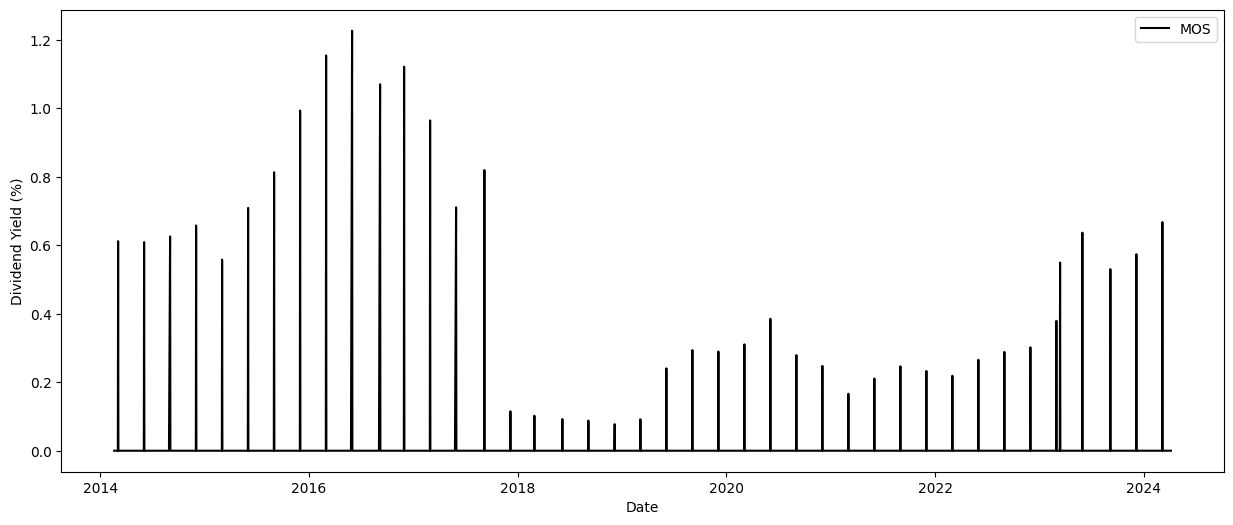

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


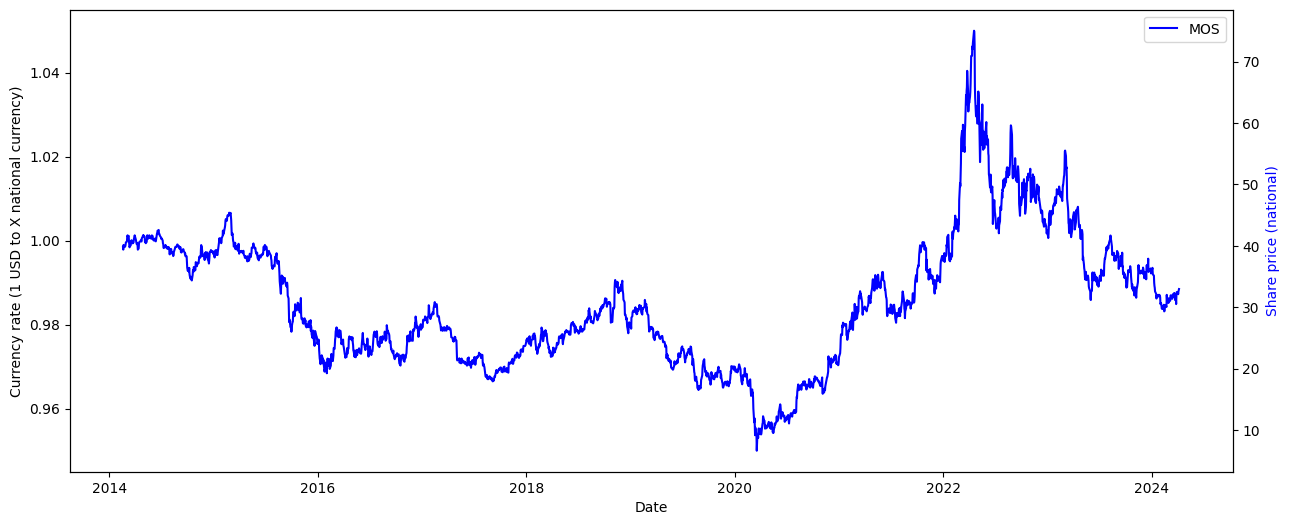

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

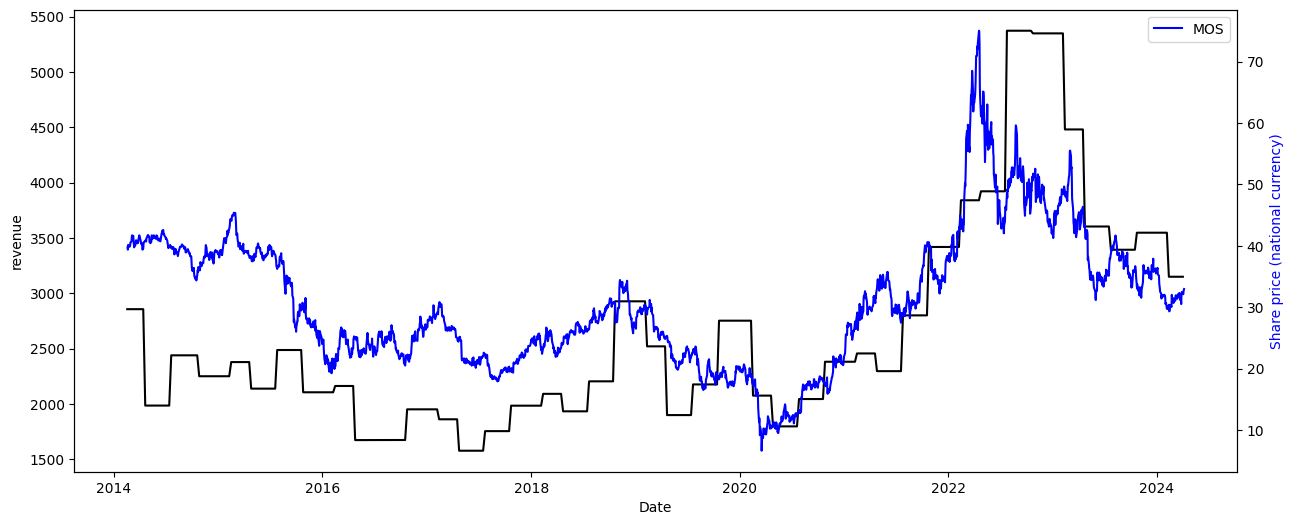

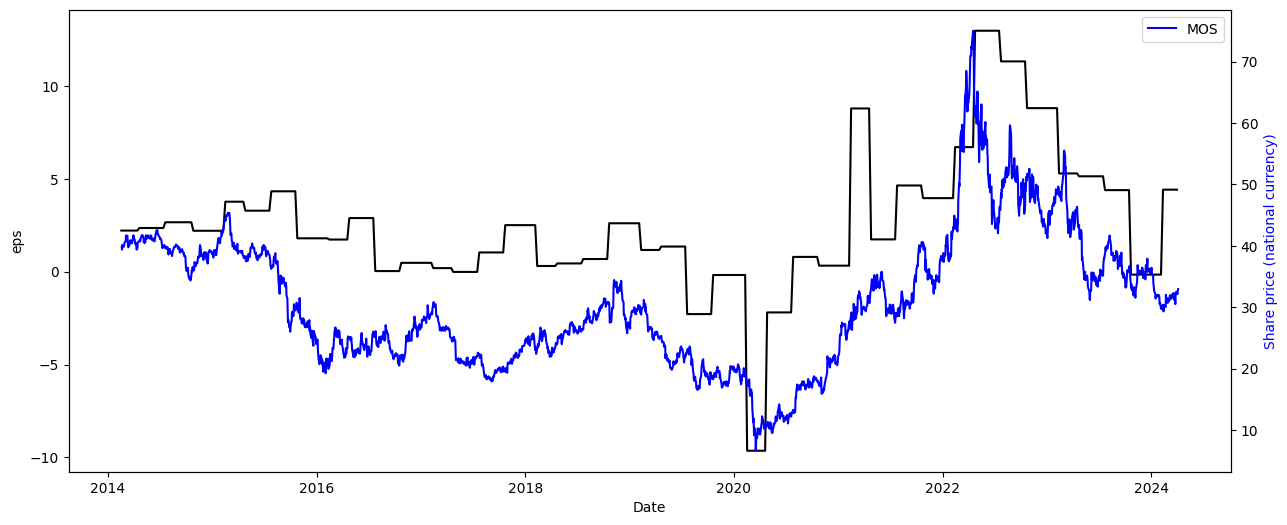

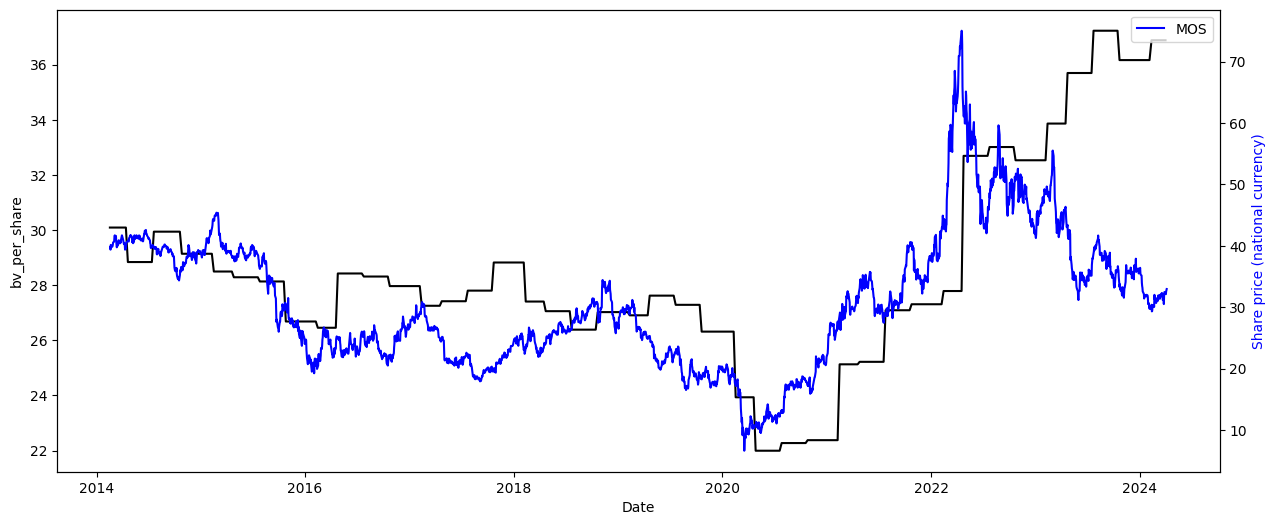

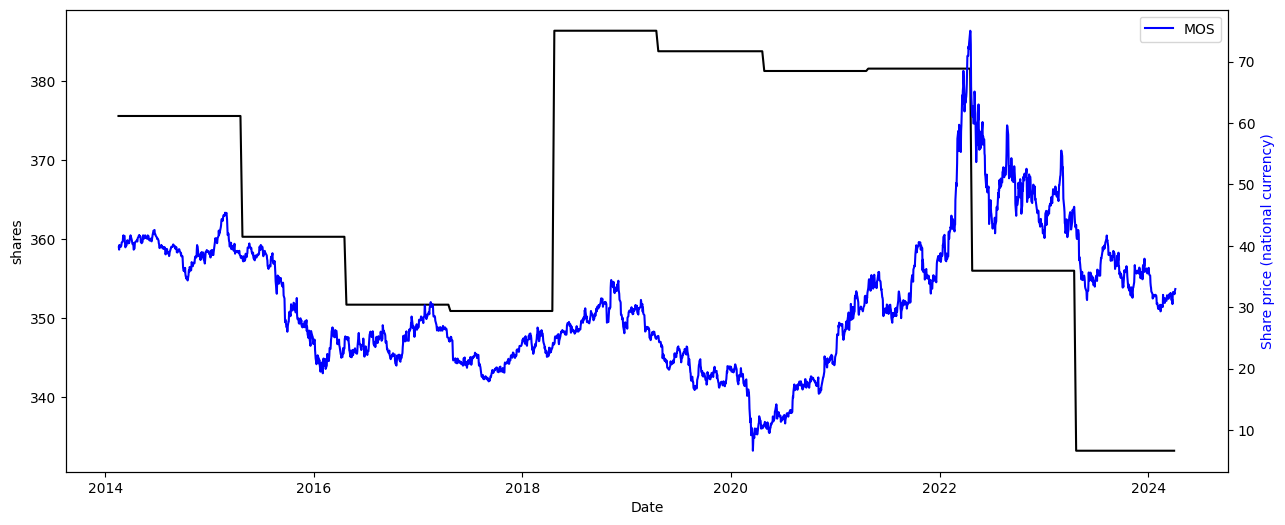

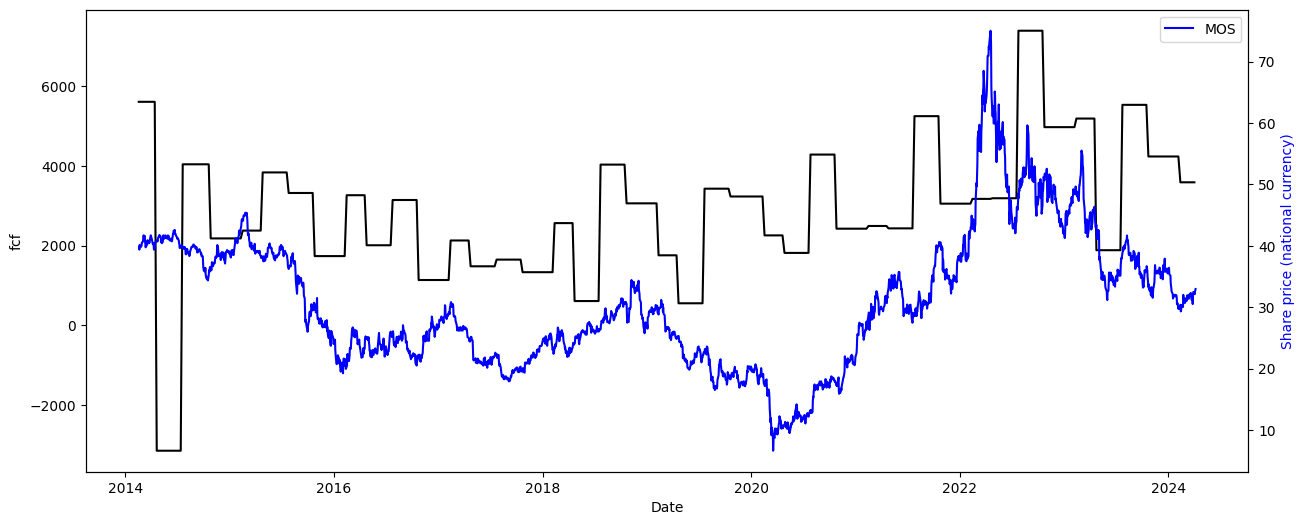

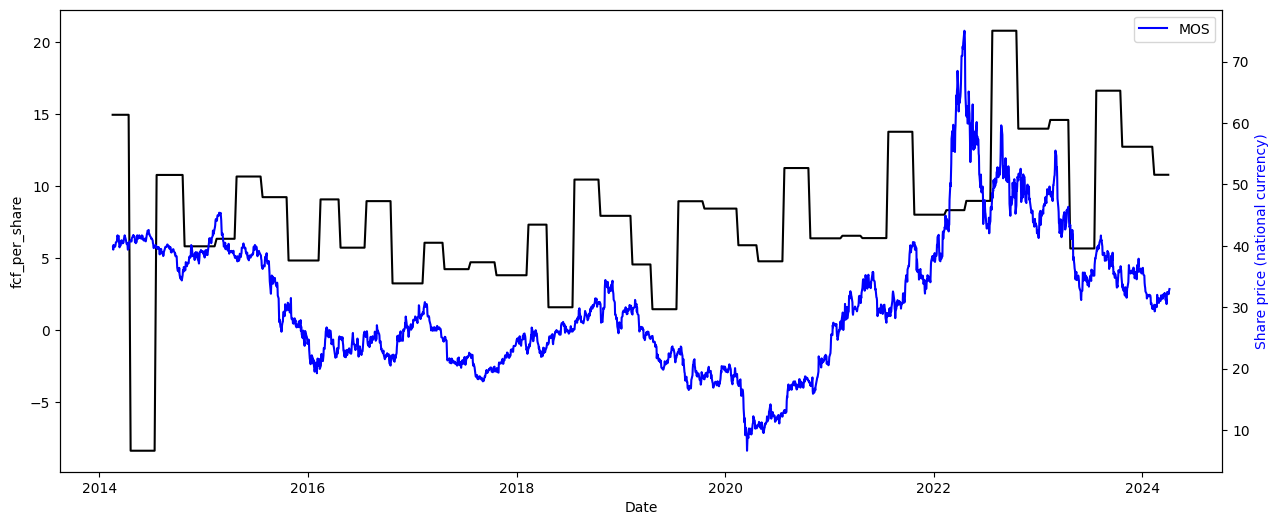

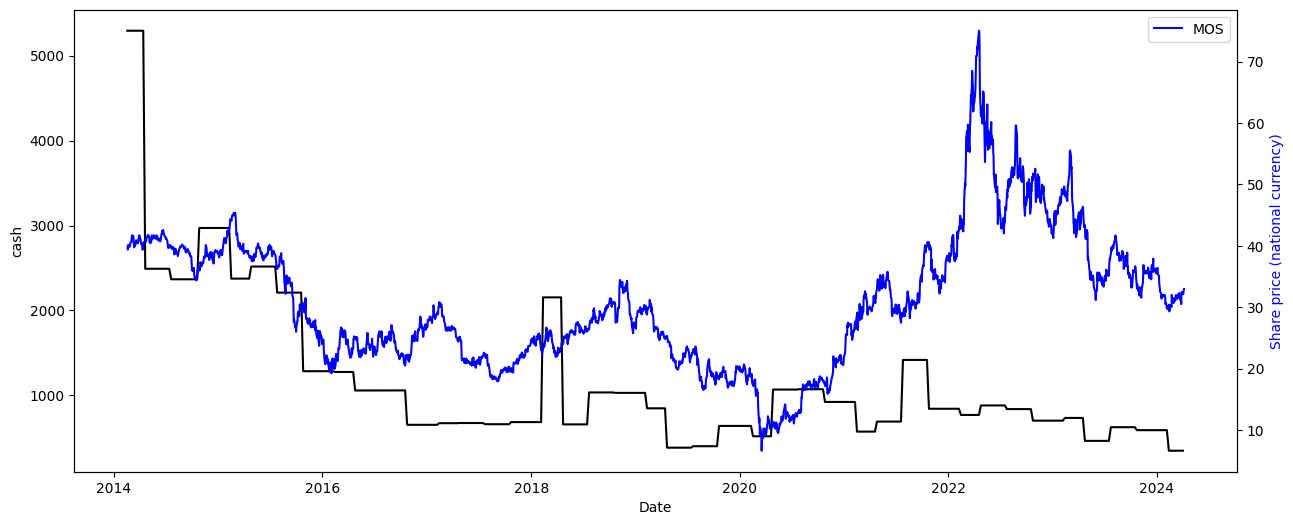

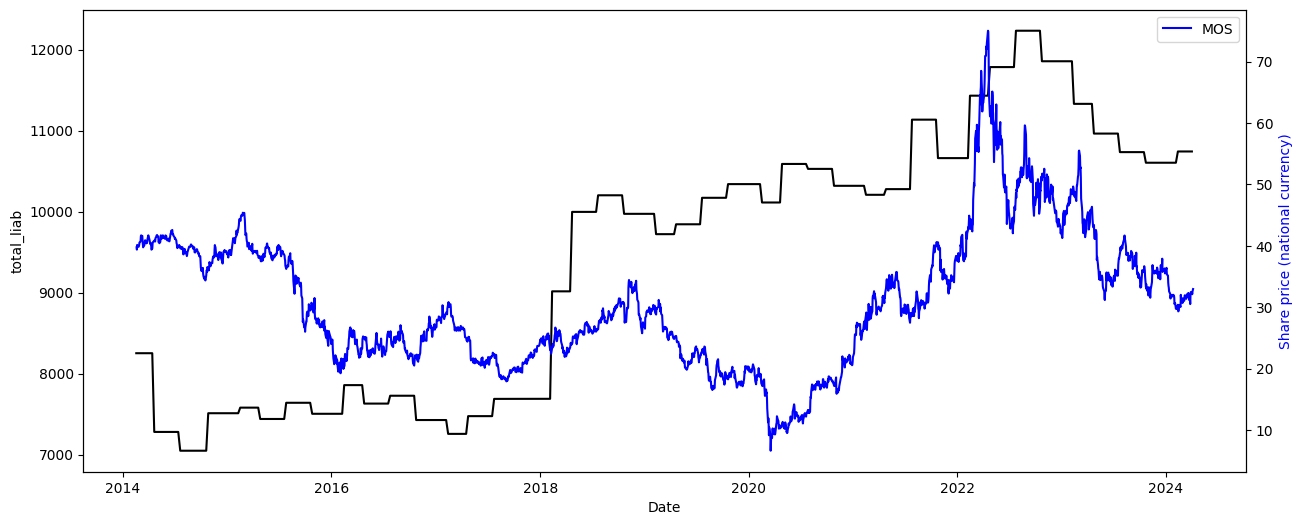

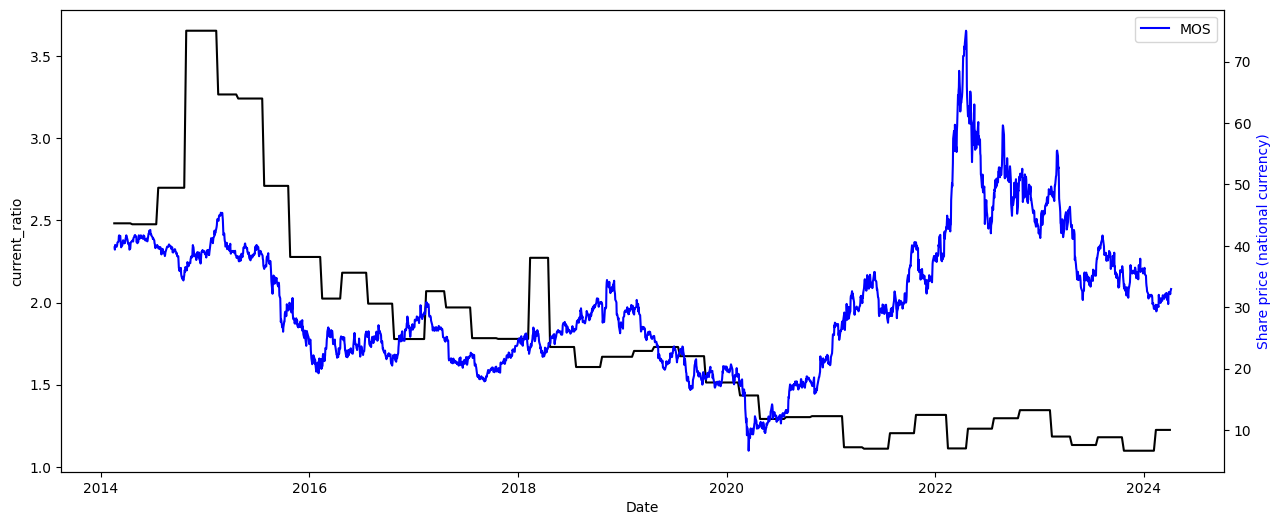

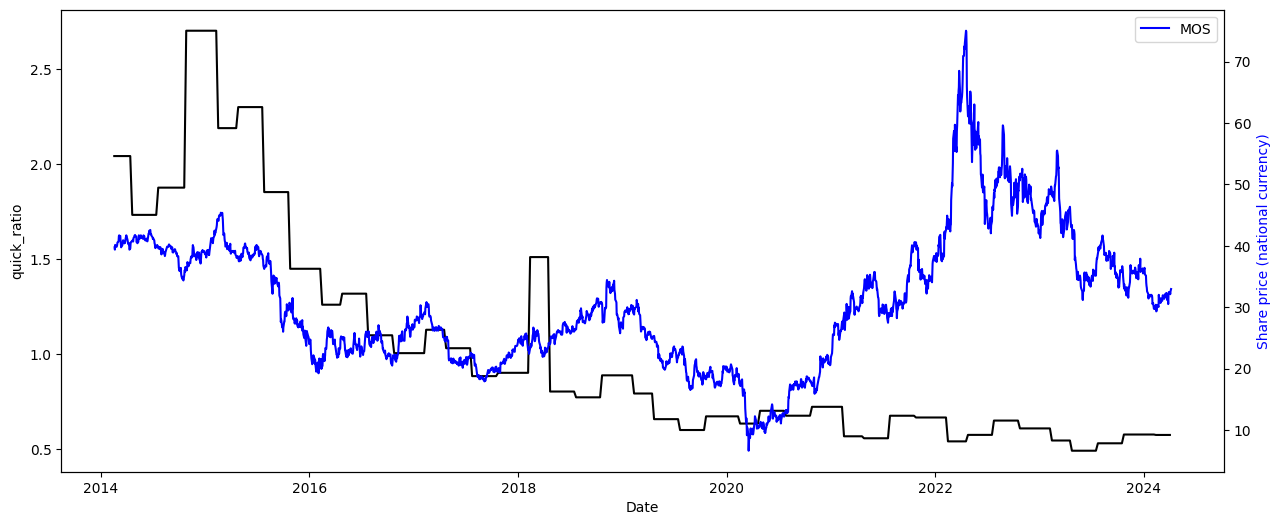

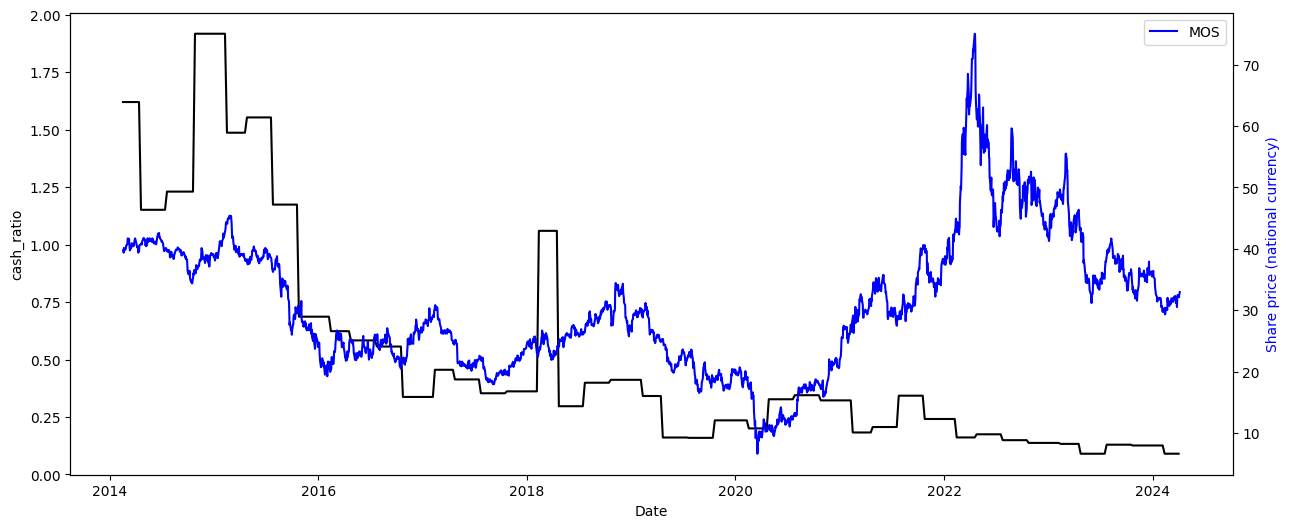

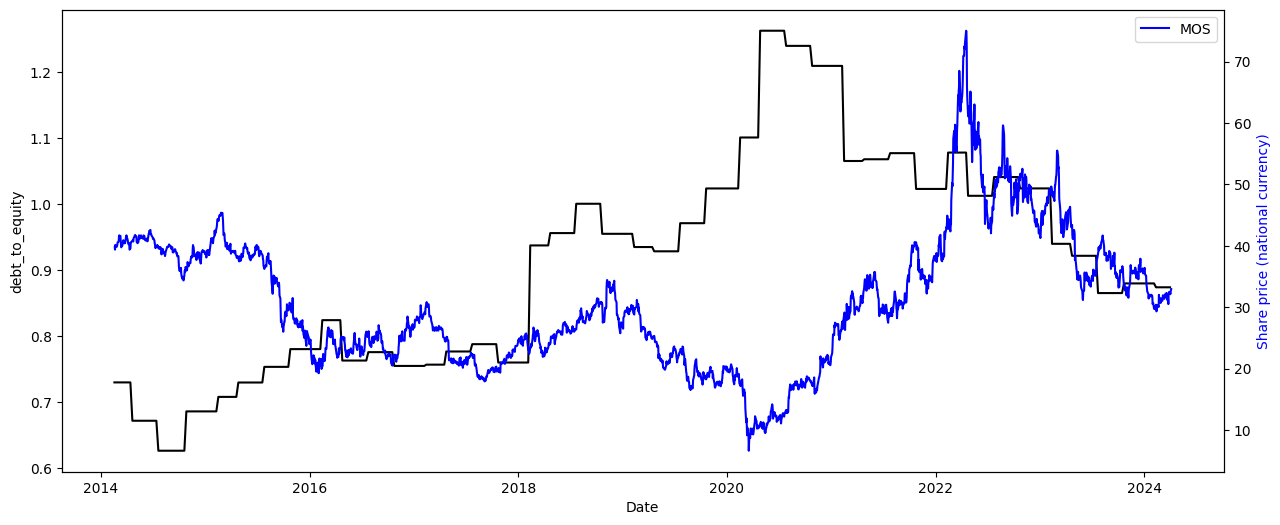

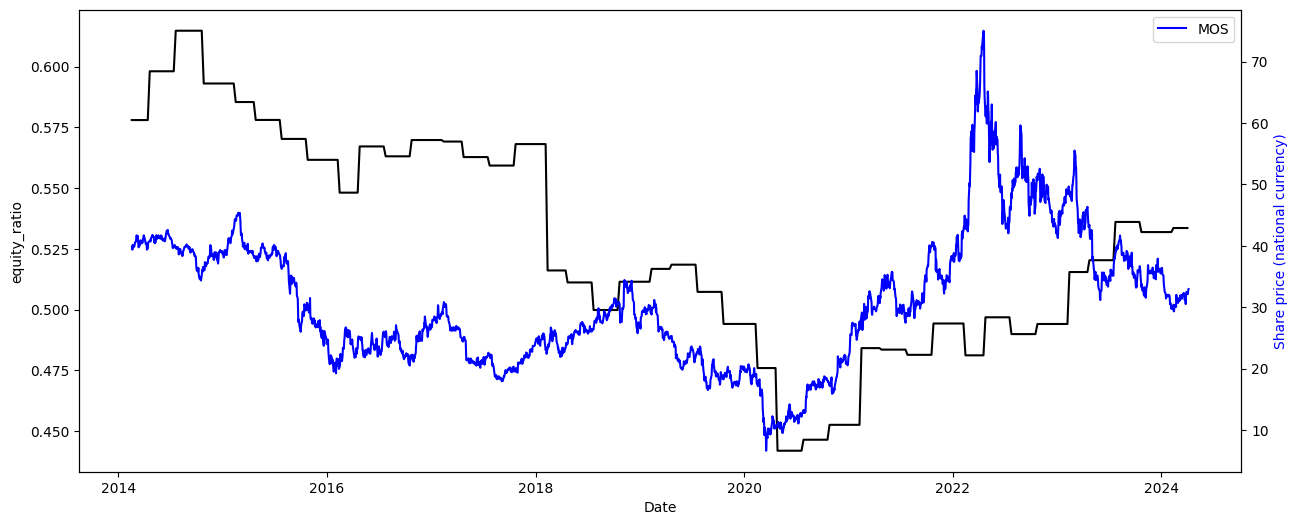

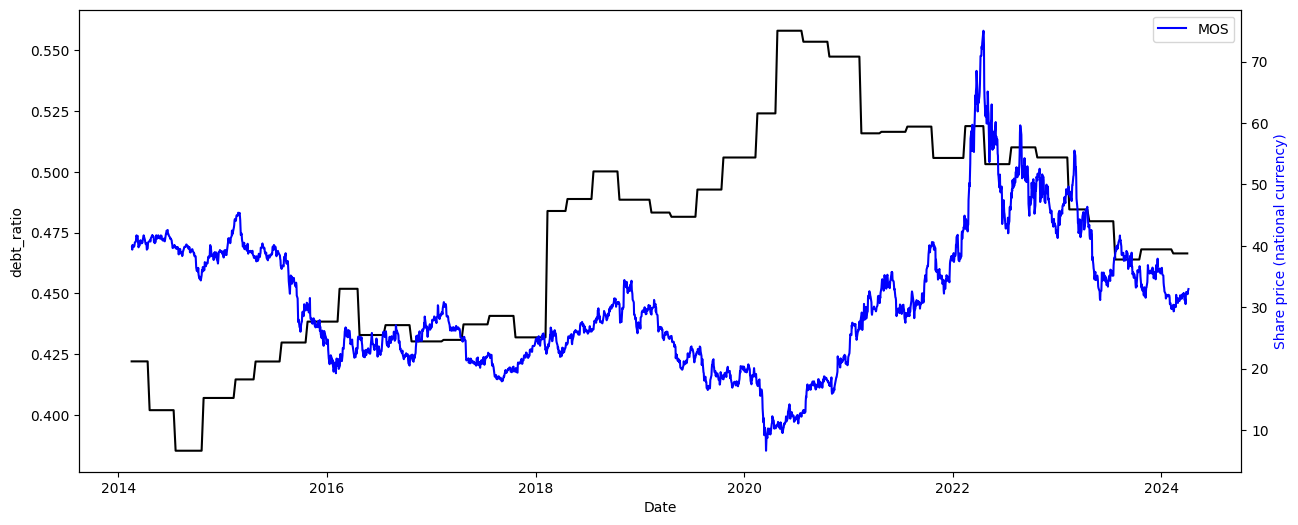

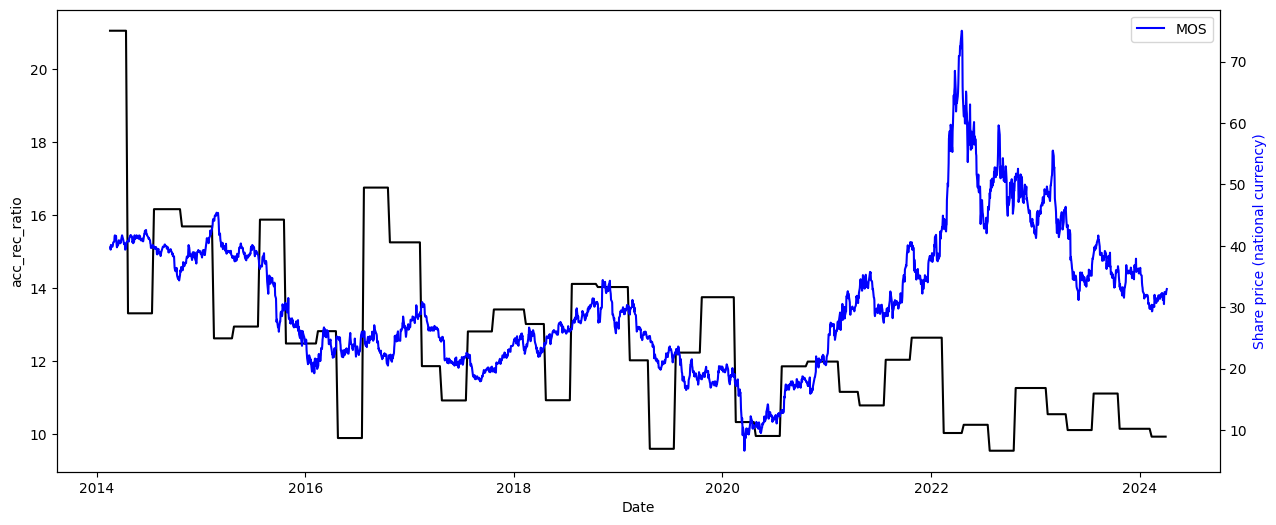

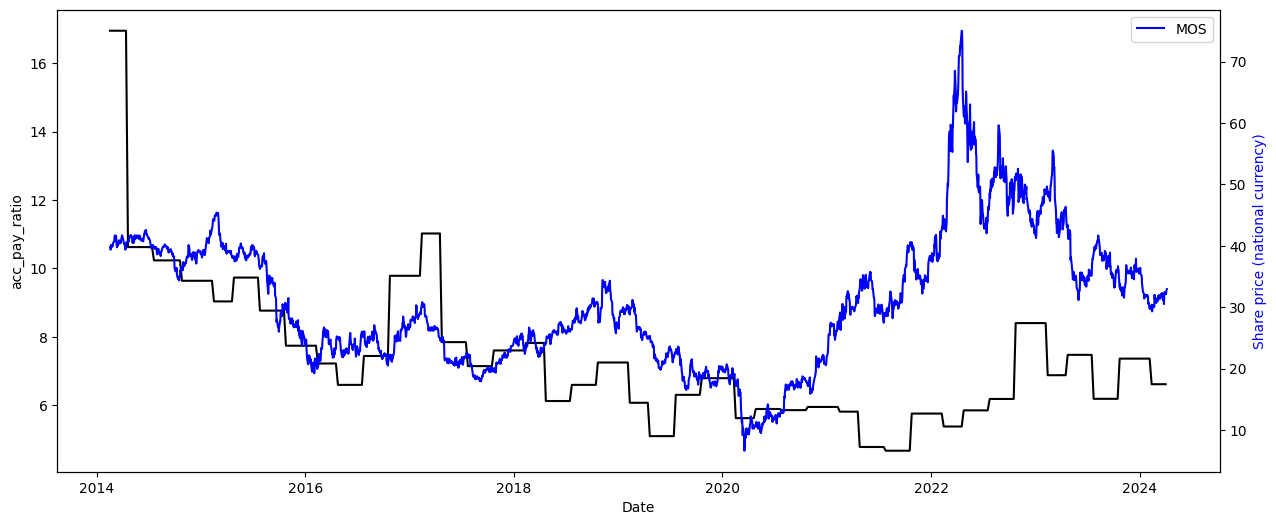

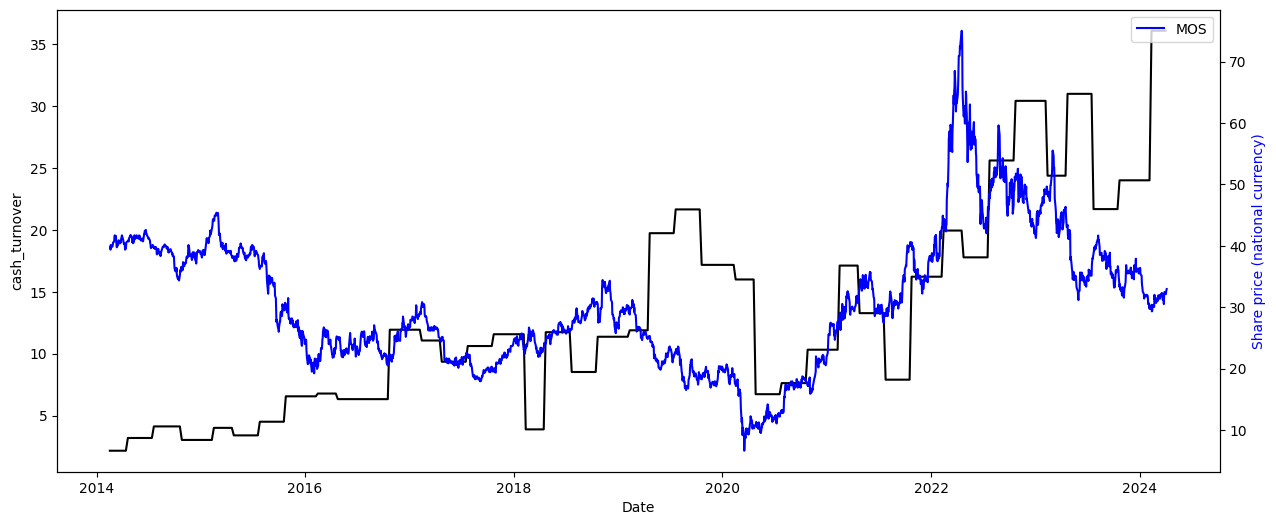

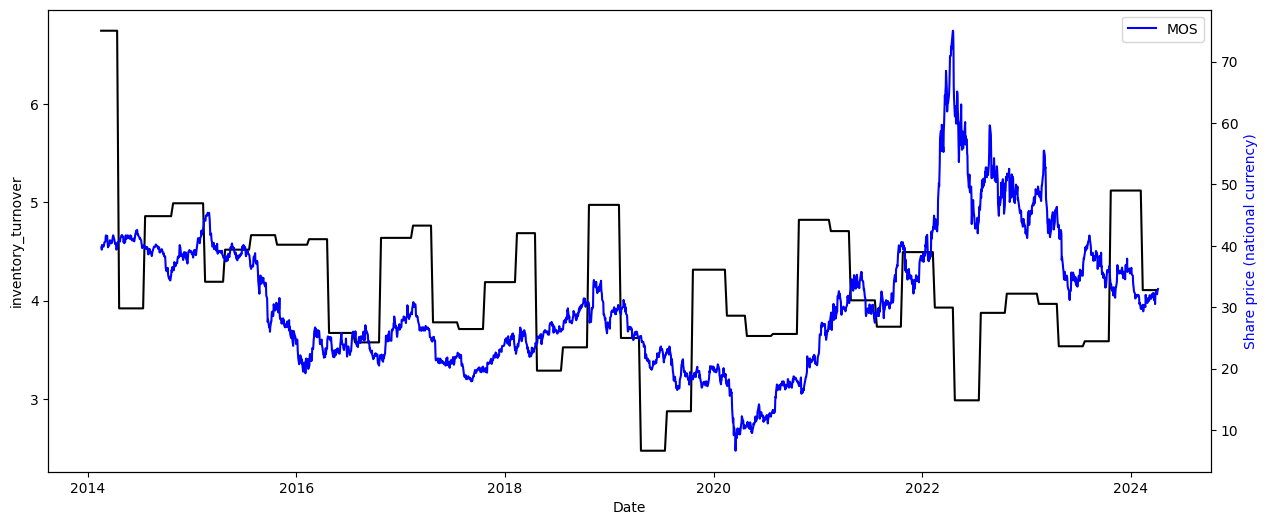

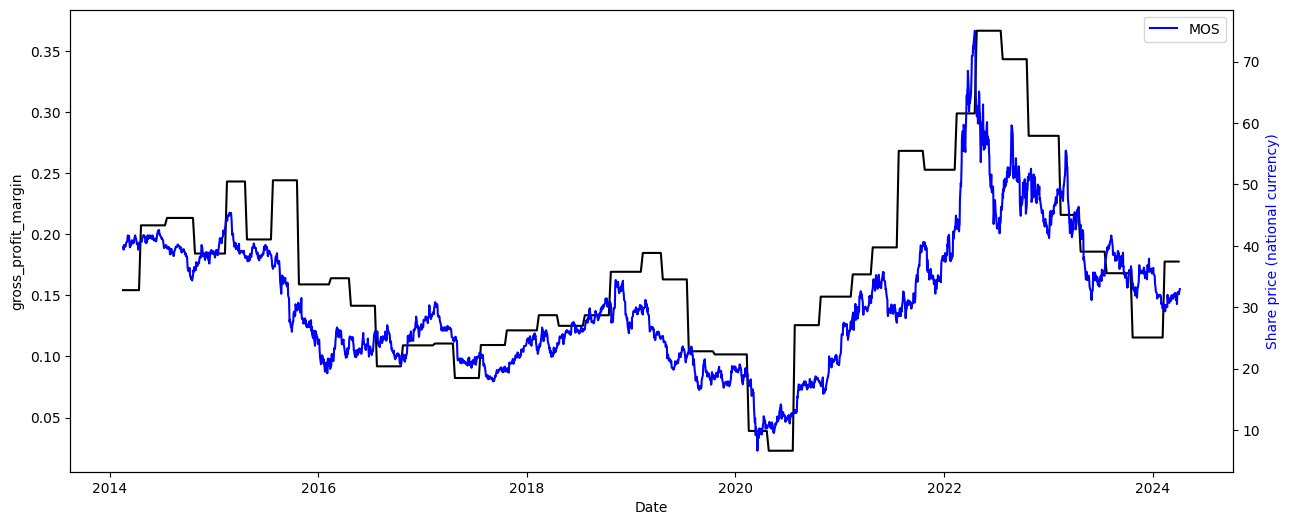

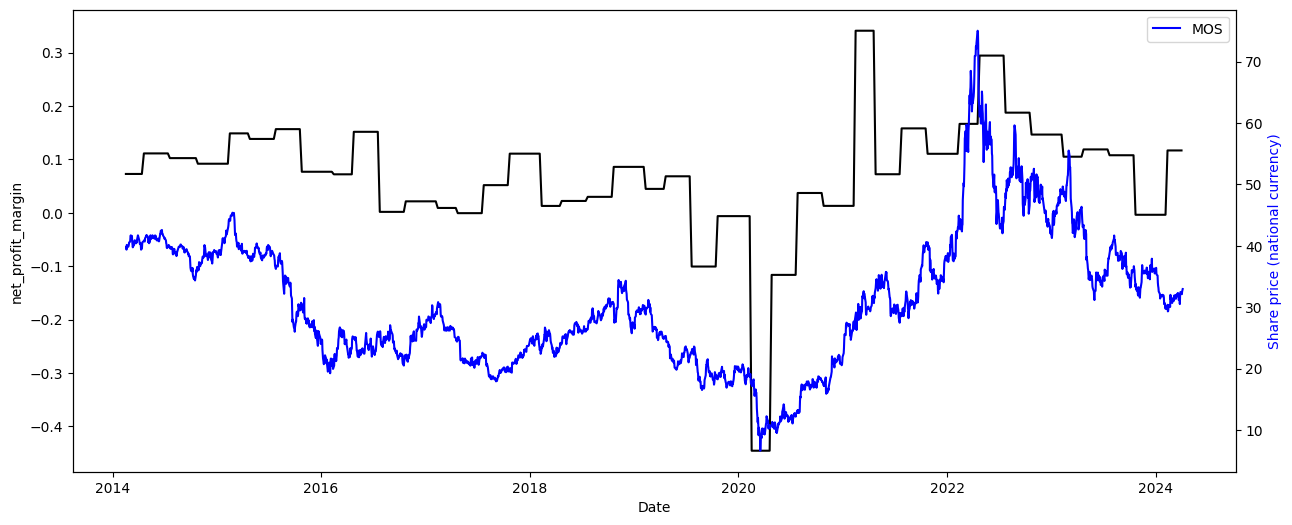

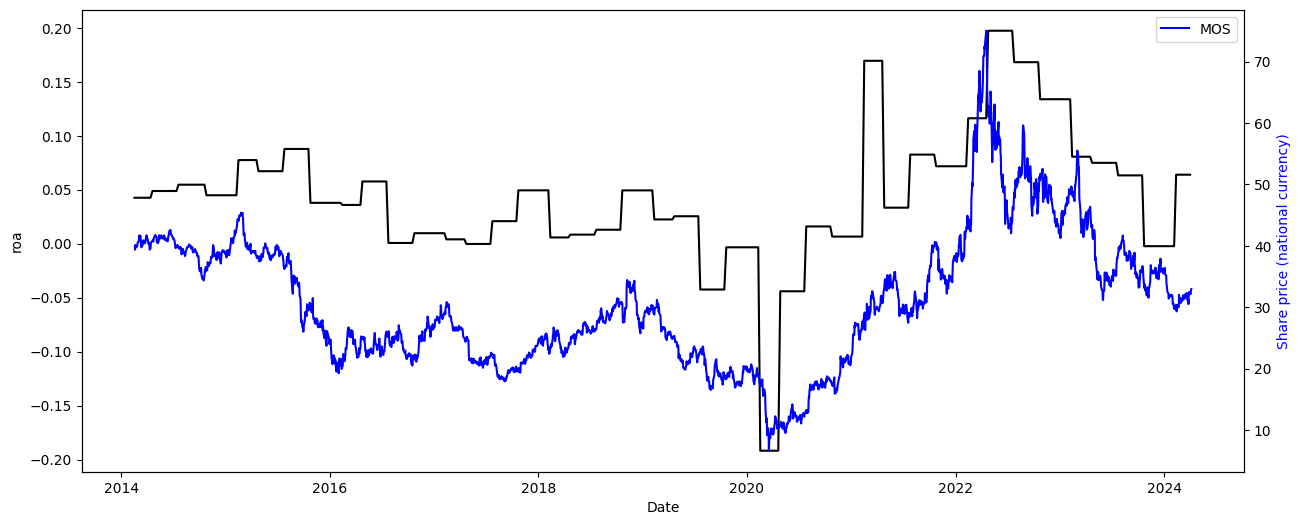

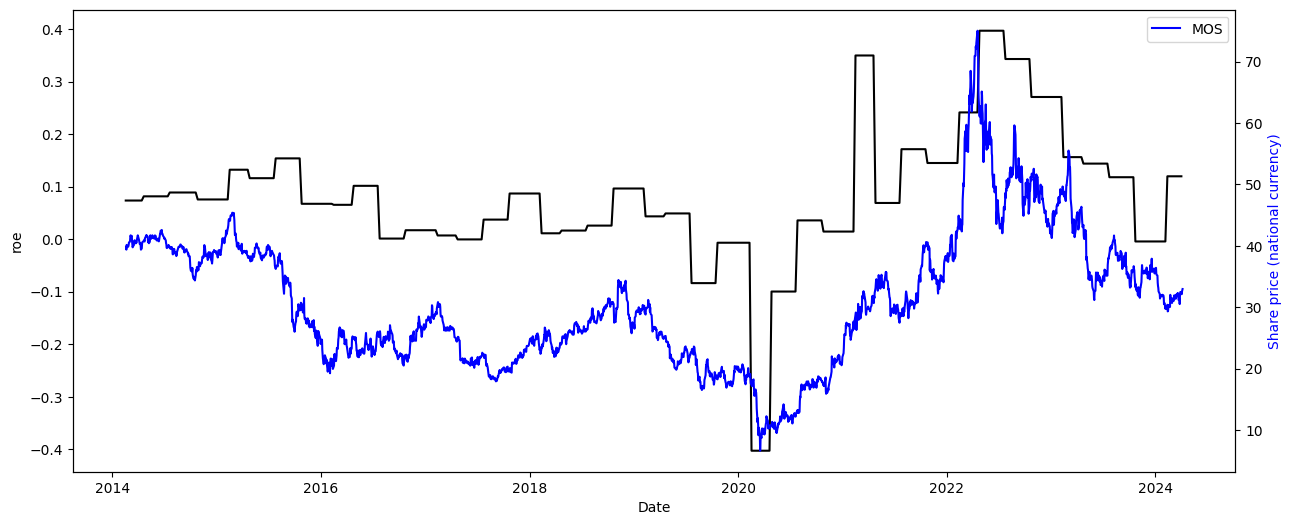

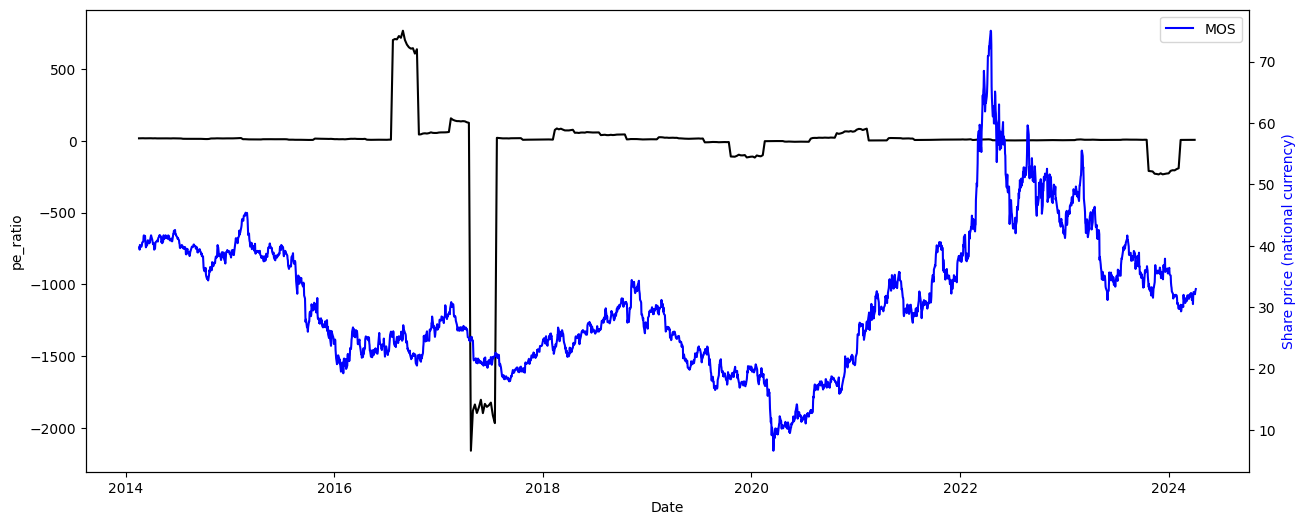

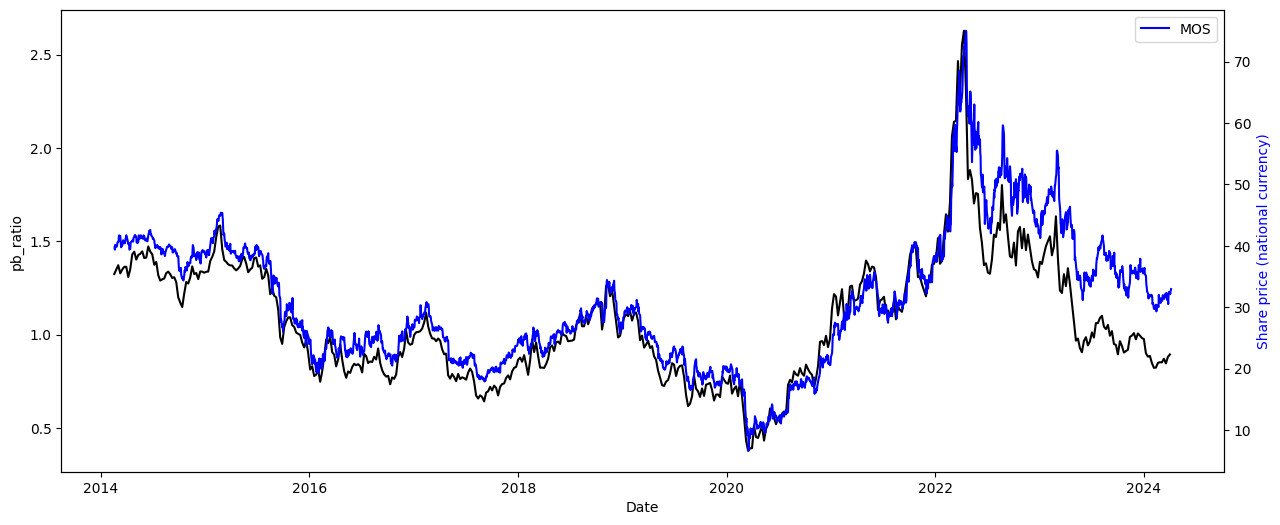

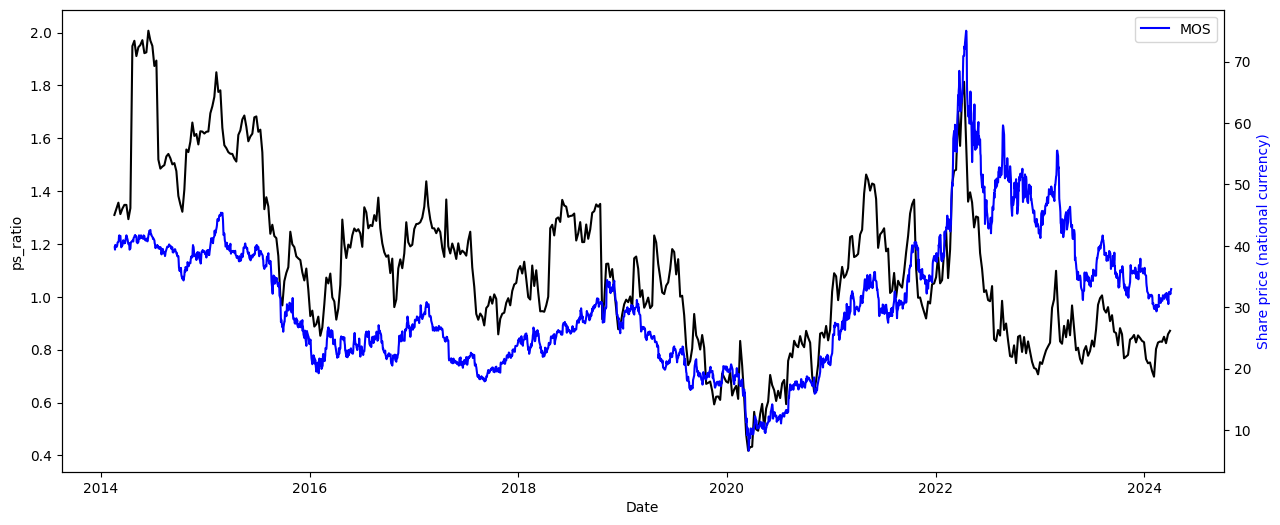

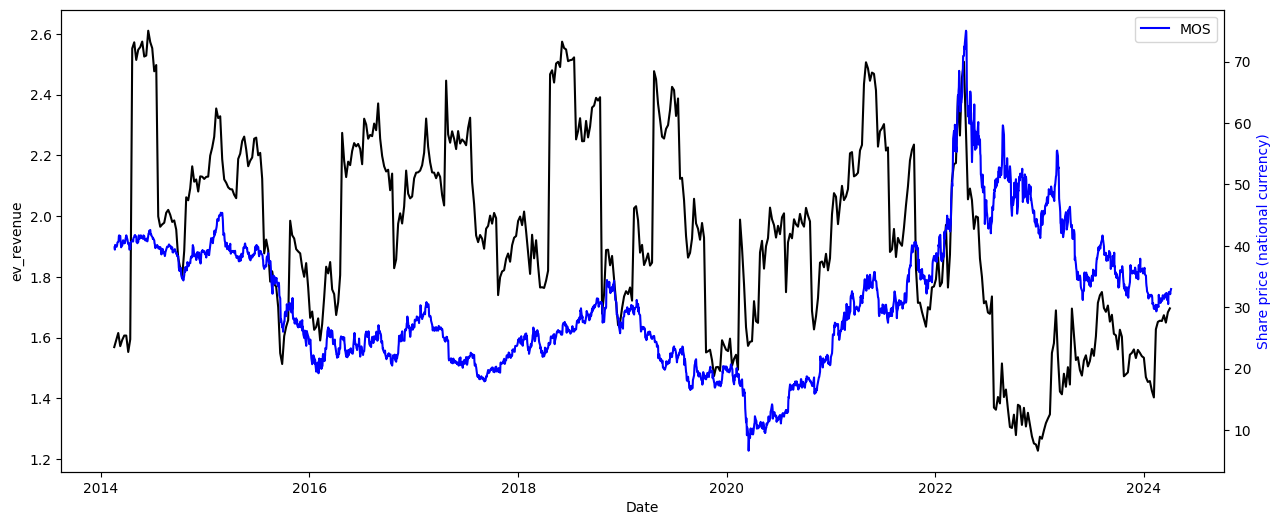

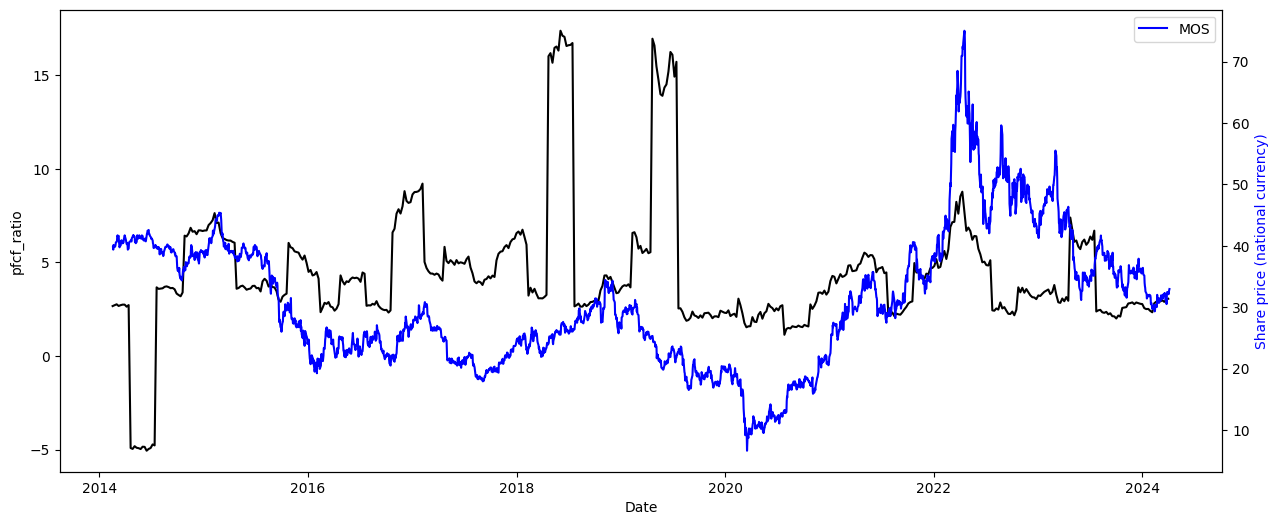

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

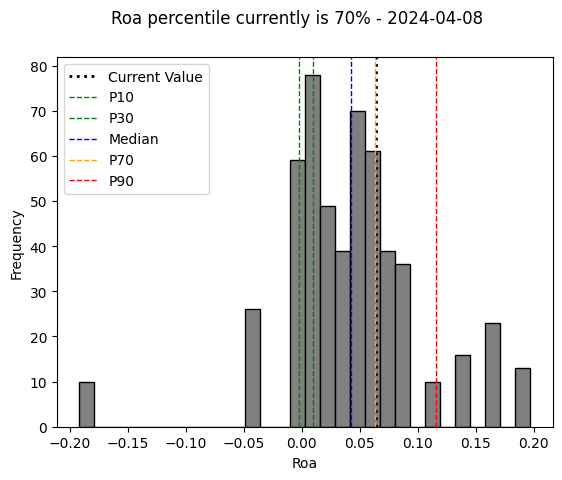

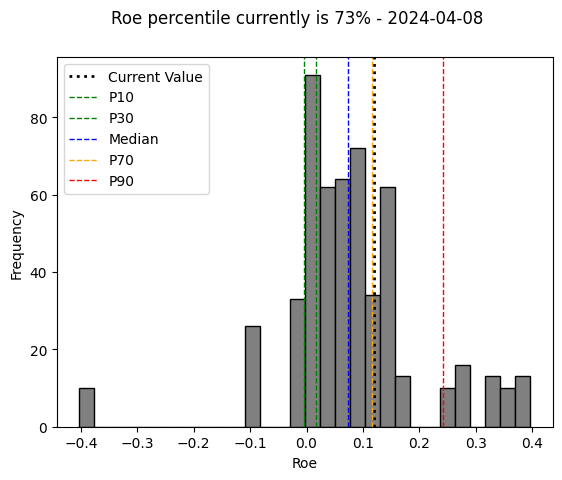

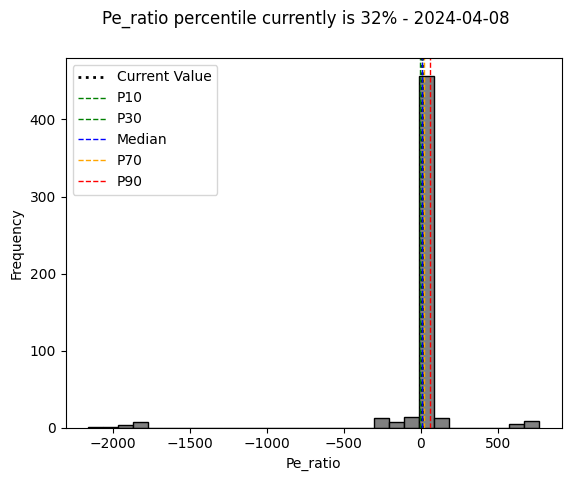

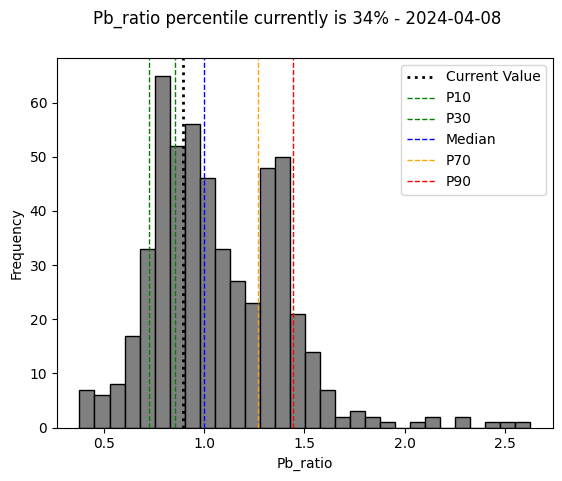

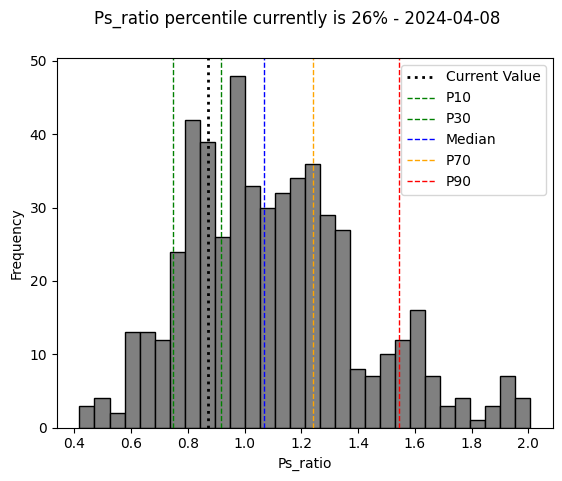

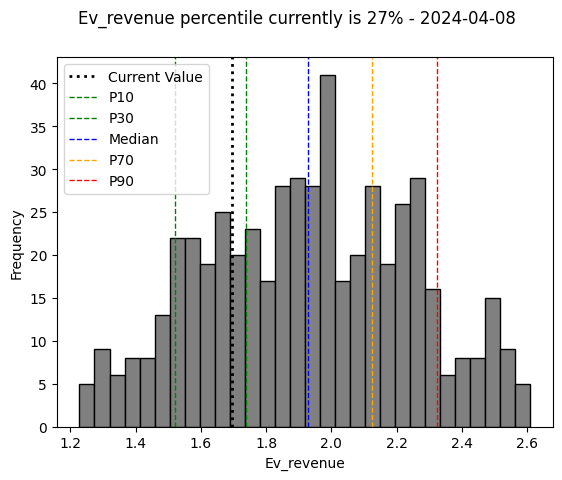

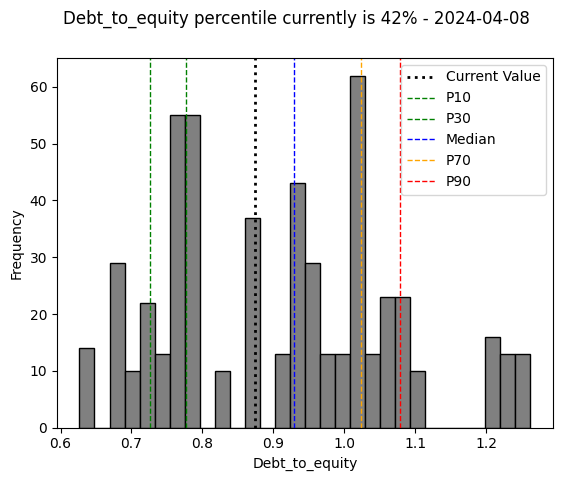

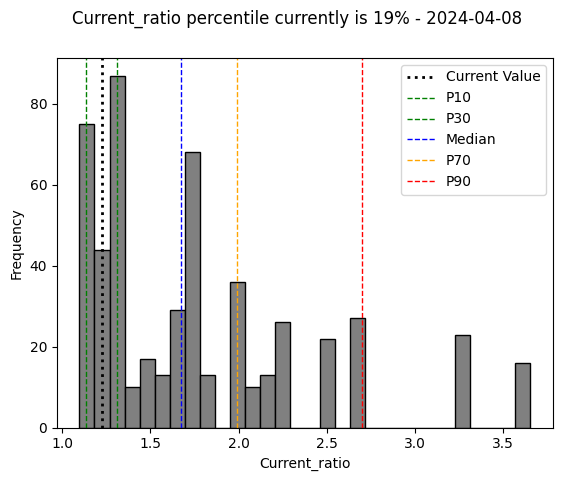

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997870,0.077064,0.701078,0.250198,-0.167954,-0.060298,-0.048566
roe,0.997870,1.000000,0.071725,0.696257,0.223958,-0.170986,-0.018176,-0.094988
pe_ratio,0.077064,0.071725,1.000000,0.104776,0.026251,-0.048221,0.068784,0.010302
pb_ratio,0.701078,0.696257,0.104776,1.000000,0.572372,0.072700,-0.070069,0.105506
ps_ratio,0.250198,0.223958,0.026251,0.572372,1.000000,0.719347,-0.579518,0.643046
ev_revenue,-0.167954,-0.170986,-0.048221,0.072700,0.719347,1.000000,-0.206976,0.324345
debt_to_equity,-0.060298,-0.018176,0.068784,-0.070069,-0.579518,-0.206976,1.000000,-0.739103
current_ratio,-0.048566,-0.094988,0.010302,0.105506,0.643046,0.324345,-0.739103,1.000000


21 timestemos have been found!


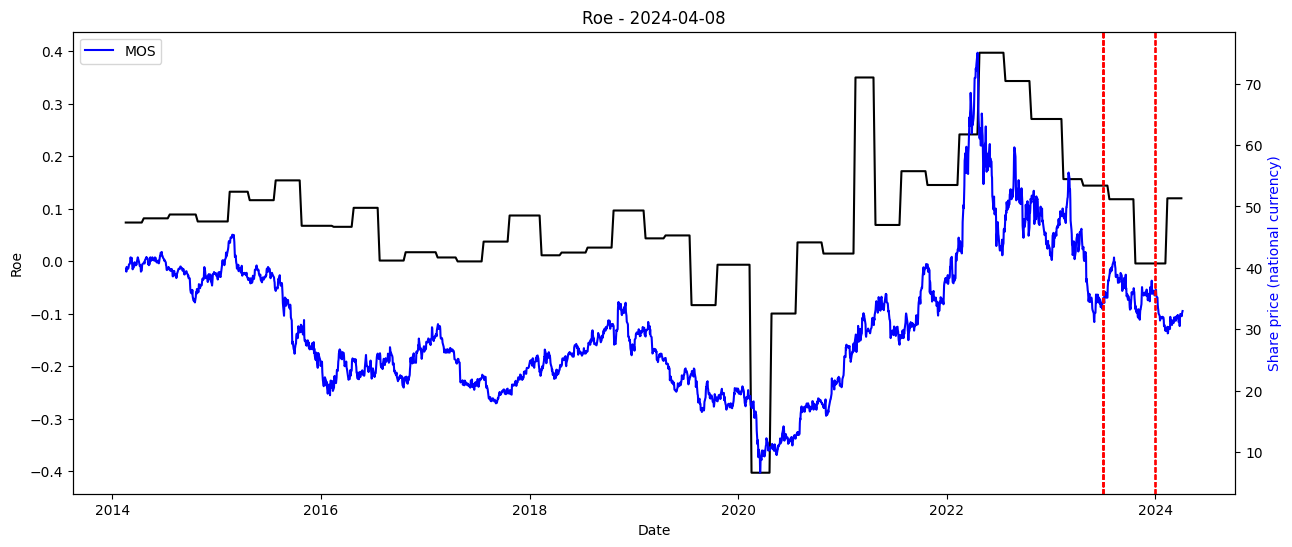

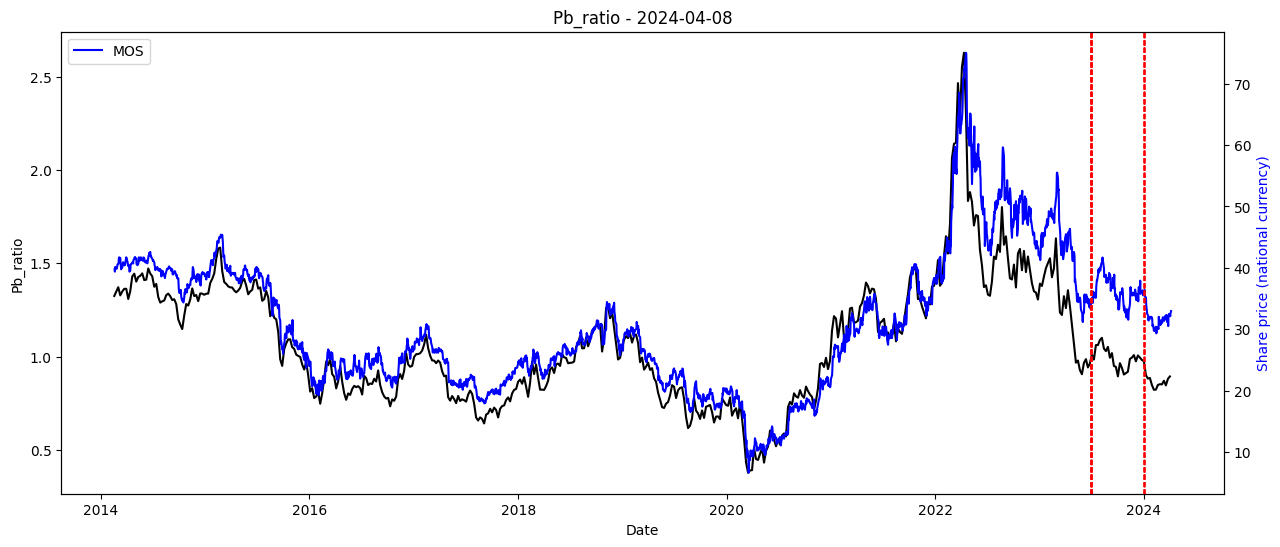

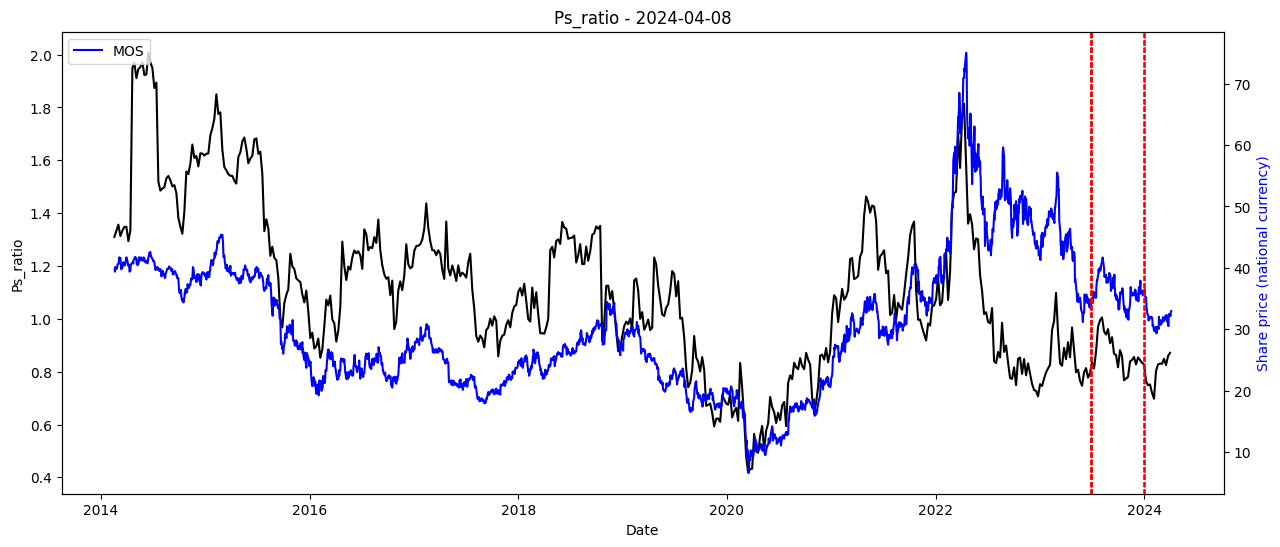

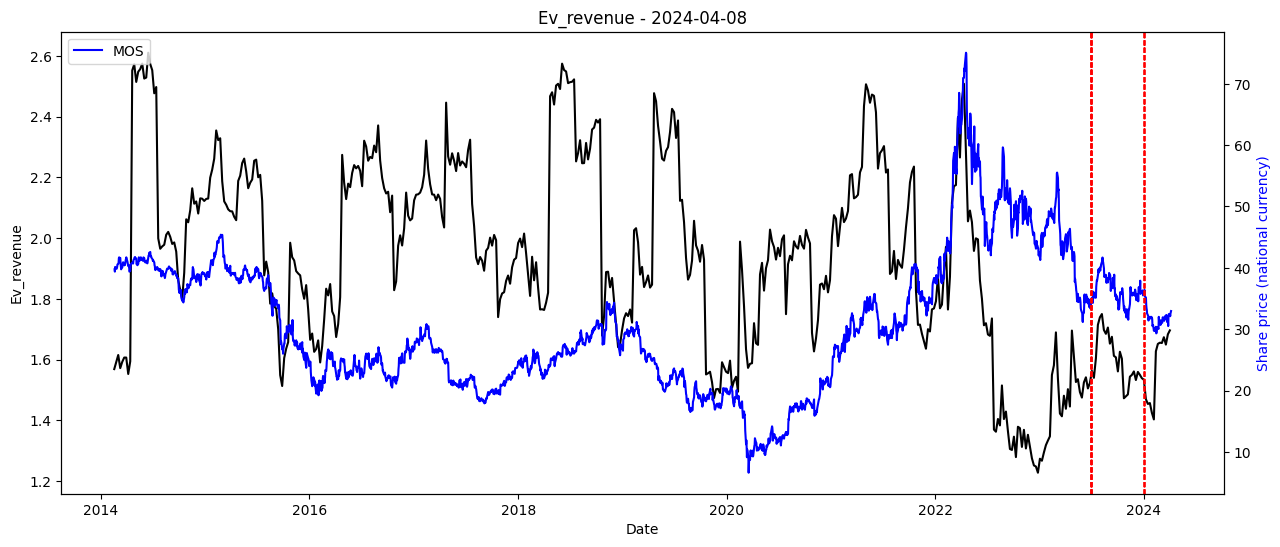

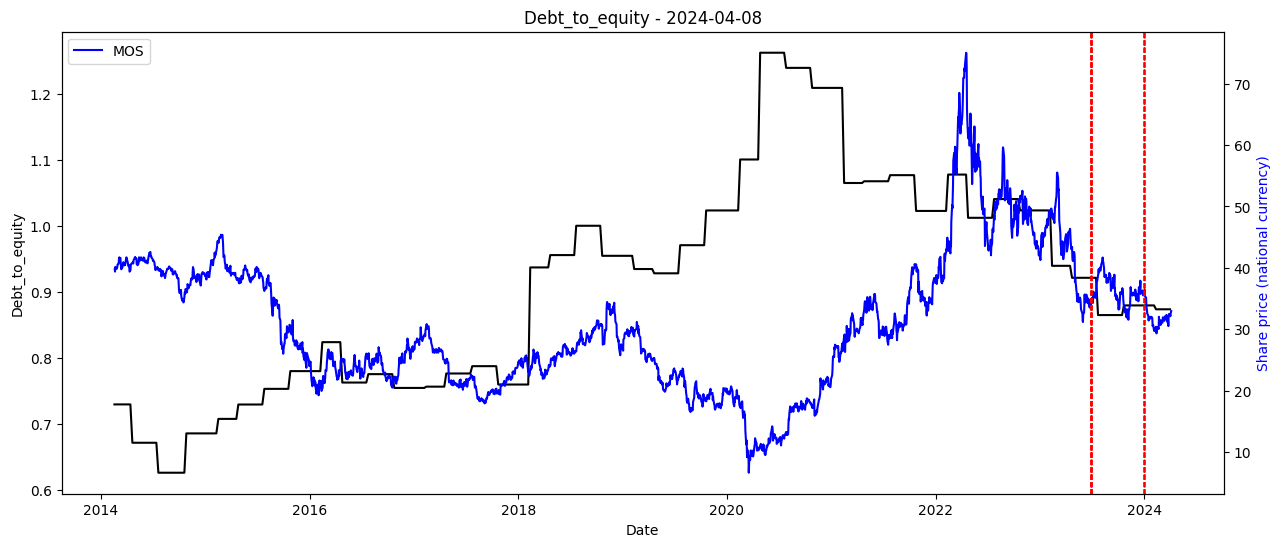

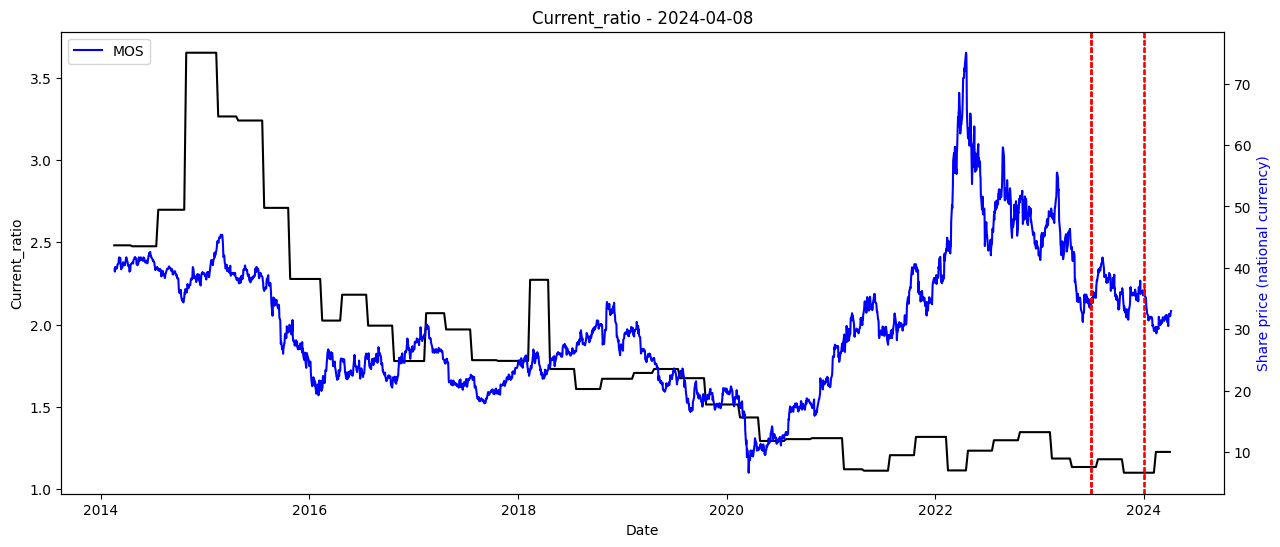

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )